In [1]:
# 处理数据示例
# from fin_data_processor import FinDataProcessor
# processor = FinDataProcessor(data_dir='./data')
# df = processor.load_data(start_date='2024-04-22', end_date='2024-9-22')
# df = processor.clean_data(df)
# df = processor.add_calendar_features(df)
# df = processor.add_features(df)
# df = processor.add_features(df,'spread')
# df.to_feather('data.feather')

In [ ]:
import pandas as pd
import factor_compute, factor_register, factor_manager, factors_test
factor_register.register_all_factors()
df = pd.read_feather('data.feather')
# factor_manager.FactorManager.get_factor_info()
# custom_config = factors_test.FactorTestConfig(
#         ic_method='spearman',
#         ic_threshold=0.03,
#         ir_threshold=0.6
#     )
# 测试单个因子
# 批量测试所有新因子
# new_factors = [
#  "microstructure_momentum"
# ]

# for factor in new_factors:
#     results = factor_compute.run_factor_compute(df, factor_name=factor)
# 测试单个因子
# 测试多个因子
factor_list = ["time_decay", "term_premium", "volume_price_trend"]
for factor in factor_list:
    results = factor_compute.run_factor_compute(df, factor_name=factor)


In [ ]:
import pandas as pd
from factor_compute import *
from factor_register import *
from factor_manager import *
from factors_test import *

df = pd.read_feather("data.feather")
Manager = FactorManager()
register_all_factors()
Manager.get_factor_info()


,name,frequency,category,description,dependencies
0,momentum_10,tick,momentum,10条Tick动量因子,
1,weighted_momentum_10,tick,momentum,10条Tick加权动量因子,
2,momentum_20,tick,momentum,20条Tick动量因子,
3,weighted_momentum_20,tick,momentum,20条Tick加权动量因子,
4,momentum_50,tick,momentum,50条Tick动量因子,
5,weighted_momentum_50,tick,momentum,50条Tick加权动量因子,
6,momentum_100,tick,momentum,100条Tick动量因子,
7,weighted_momentum_100,tick,momentum,100条Tick加权动量因子,
8,momentum_300,minute,momentum,300条数据动量因子,
9,momentum_600,minute,momentum,600条数据动量因子,



=== 测试时间特征类因子 ===

测试因子: intraday_seasonality

计算收益率周期: [1, 5, 10, 20]

原始数据形状: (1899132, 70)

开始计算因子: intraday_seasonality
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_dat

/Users/okko_dyd/Desktop/富国实习/factor_register.py:404: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result['minute'] = pd.to_datetime(result['UpdateTime']).dt.minute



因子计算完成!

添加因子后数据形状: (1899132, 71)

添加收益率后数据形状: (1899132, 75)

=== 开始测试因子: intraday_seasonality ===

=== intraday_seasonality 因子评估结果 ===

有效性: 有效
评分: 4/4

关键指标:
- ic_mean: -0.0365
- ir: -0.8179
- t_stat: -8.3413
- ic_positive_ratio: 0.2404
- n_samples: 104.0000

评估意见:
- IC均值(-0.0365)通过阈值检验
- IR(-0.8179)通过阈值检验
- t统计量(-8.3413)通过阈值检验
- IC方向稳定性良好(positive_ratio=0.2404)
- 有效样本量: 104


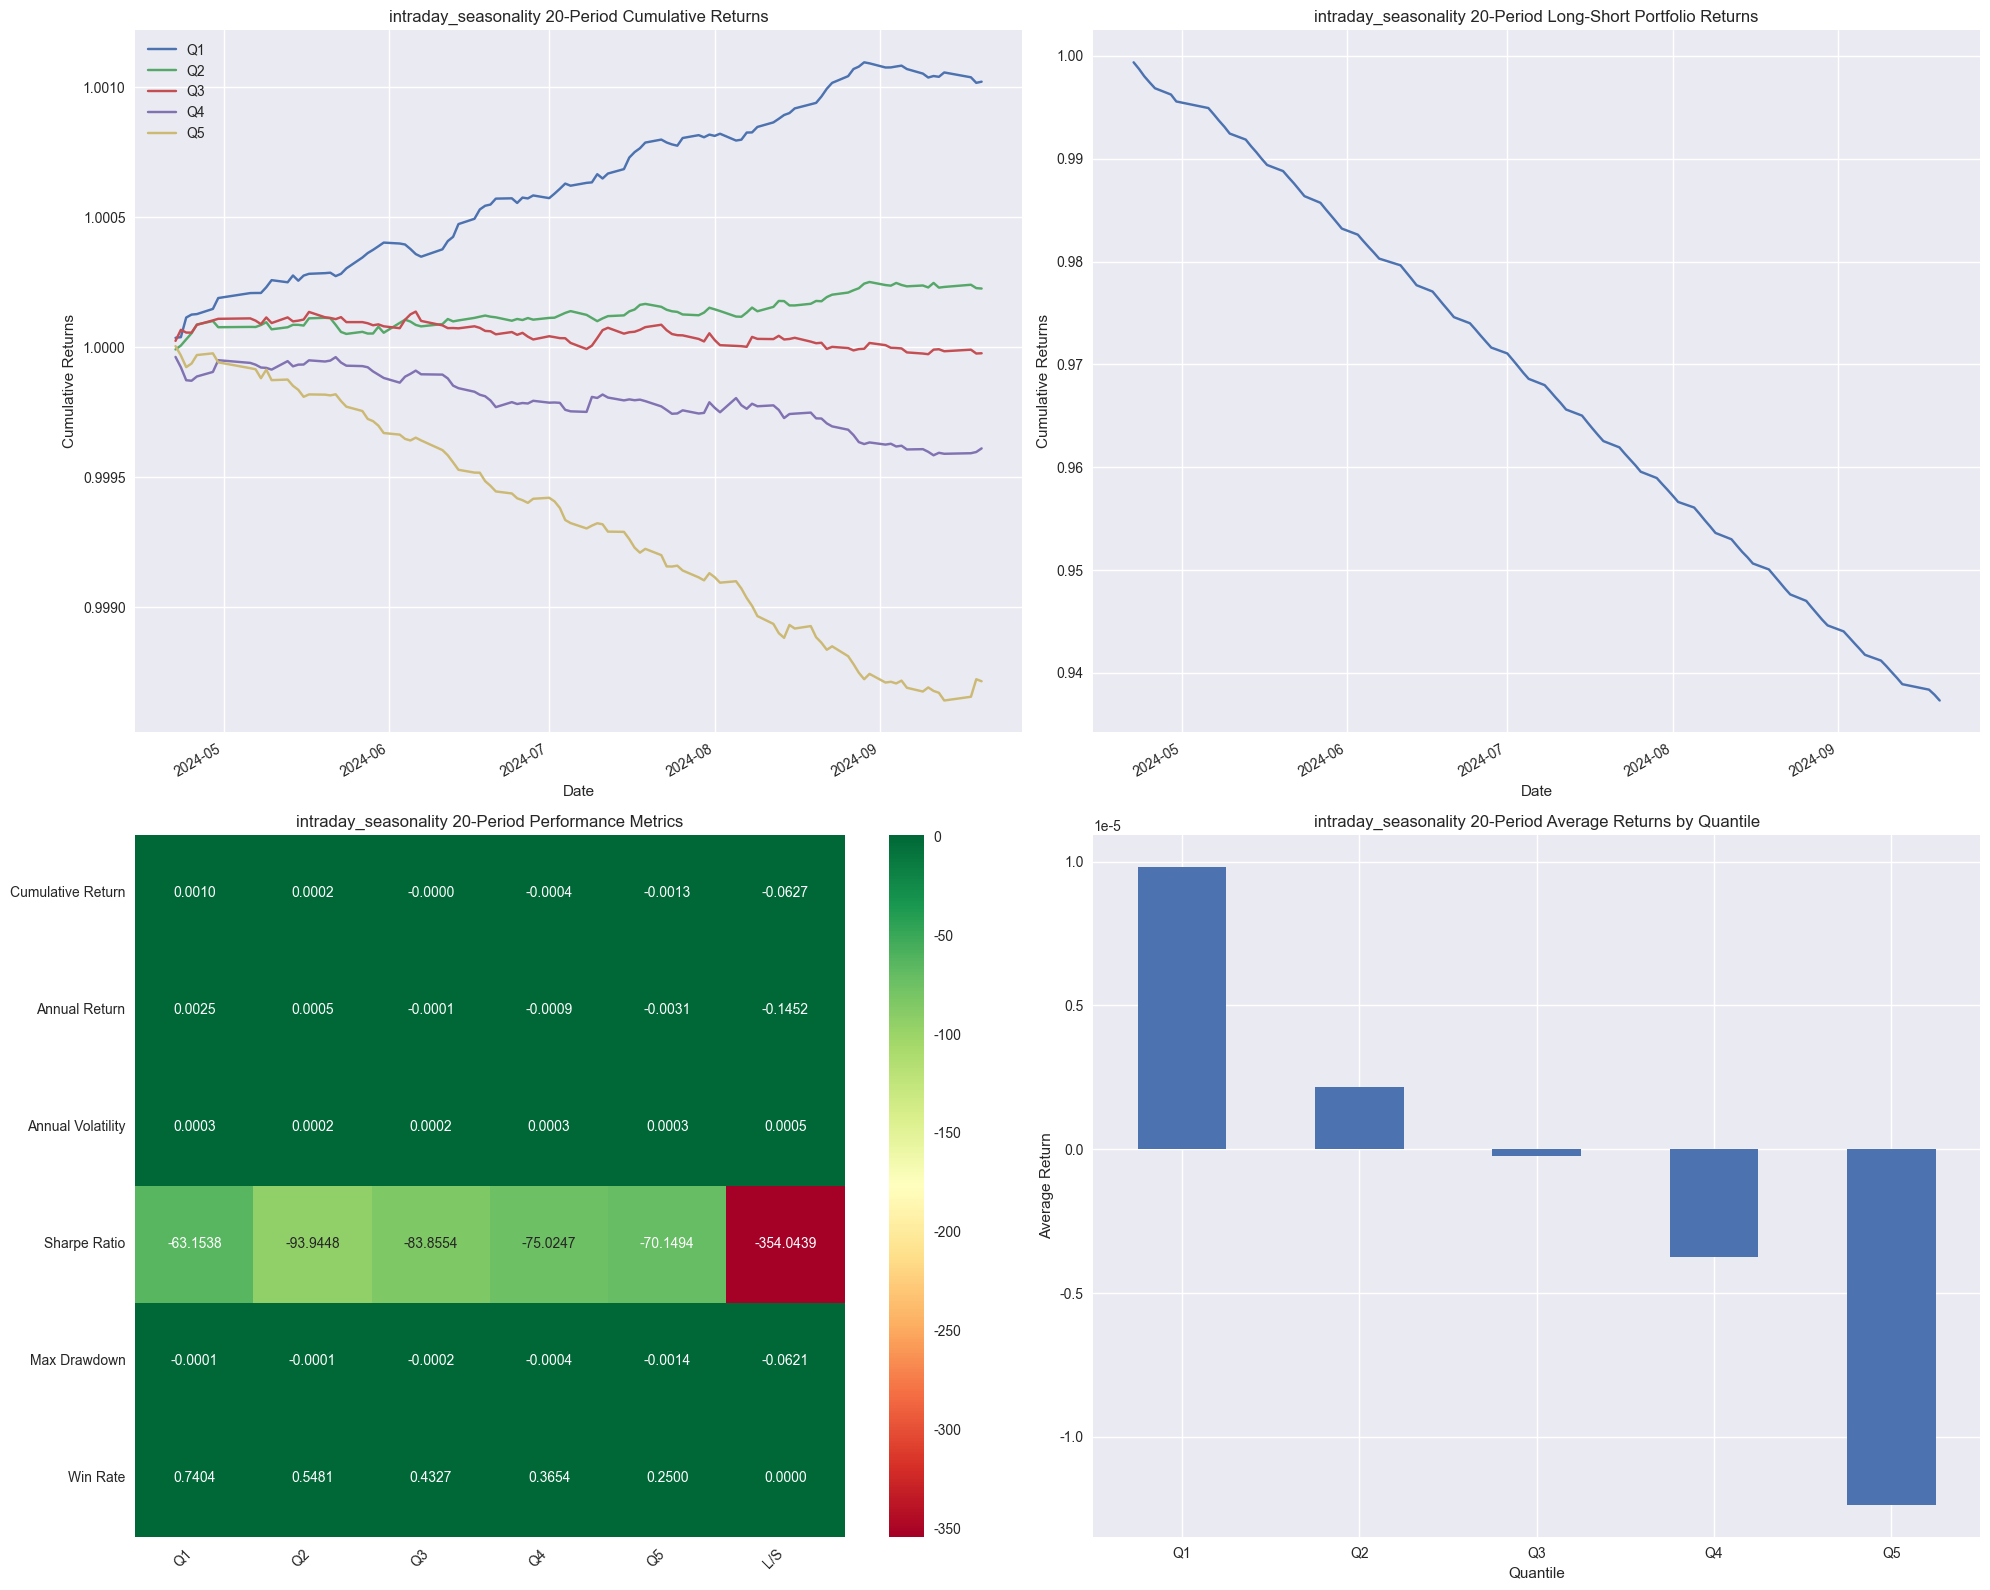


=== 测试期限结构类因子 ===

测试因子: term_premium

计算收益率周期: [5, 10, 20]

原始数据形状: (1899132, 70)

开始计算因子: term_premium
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_date', 'days_to_expiry

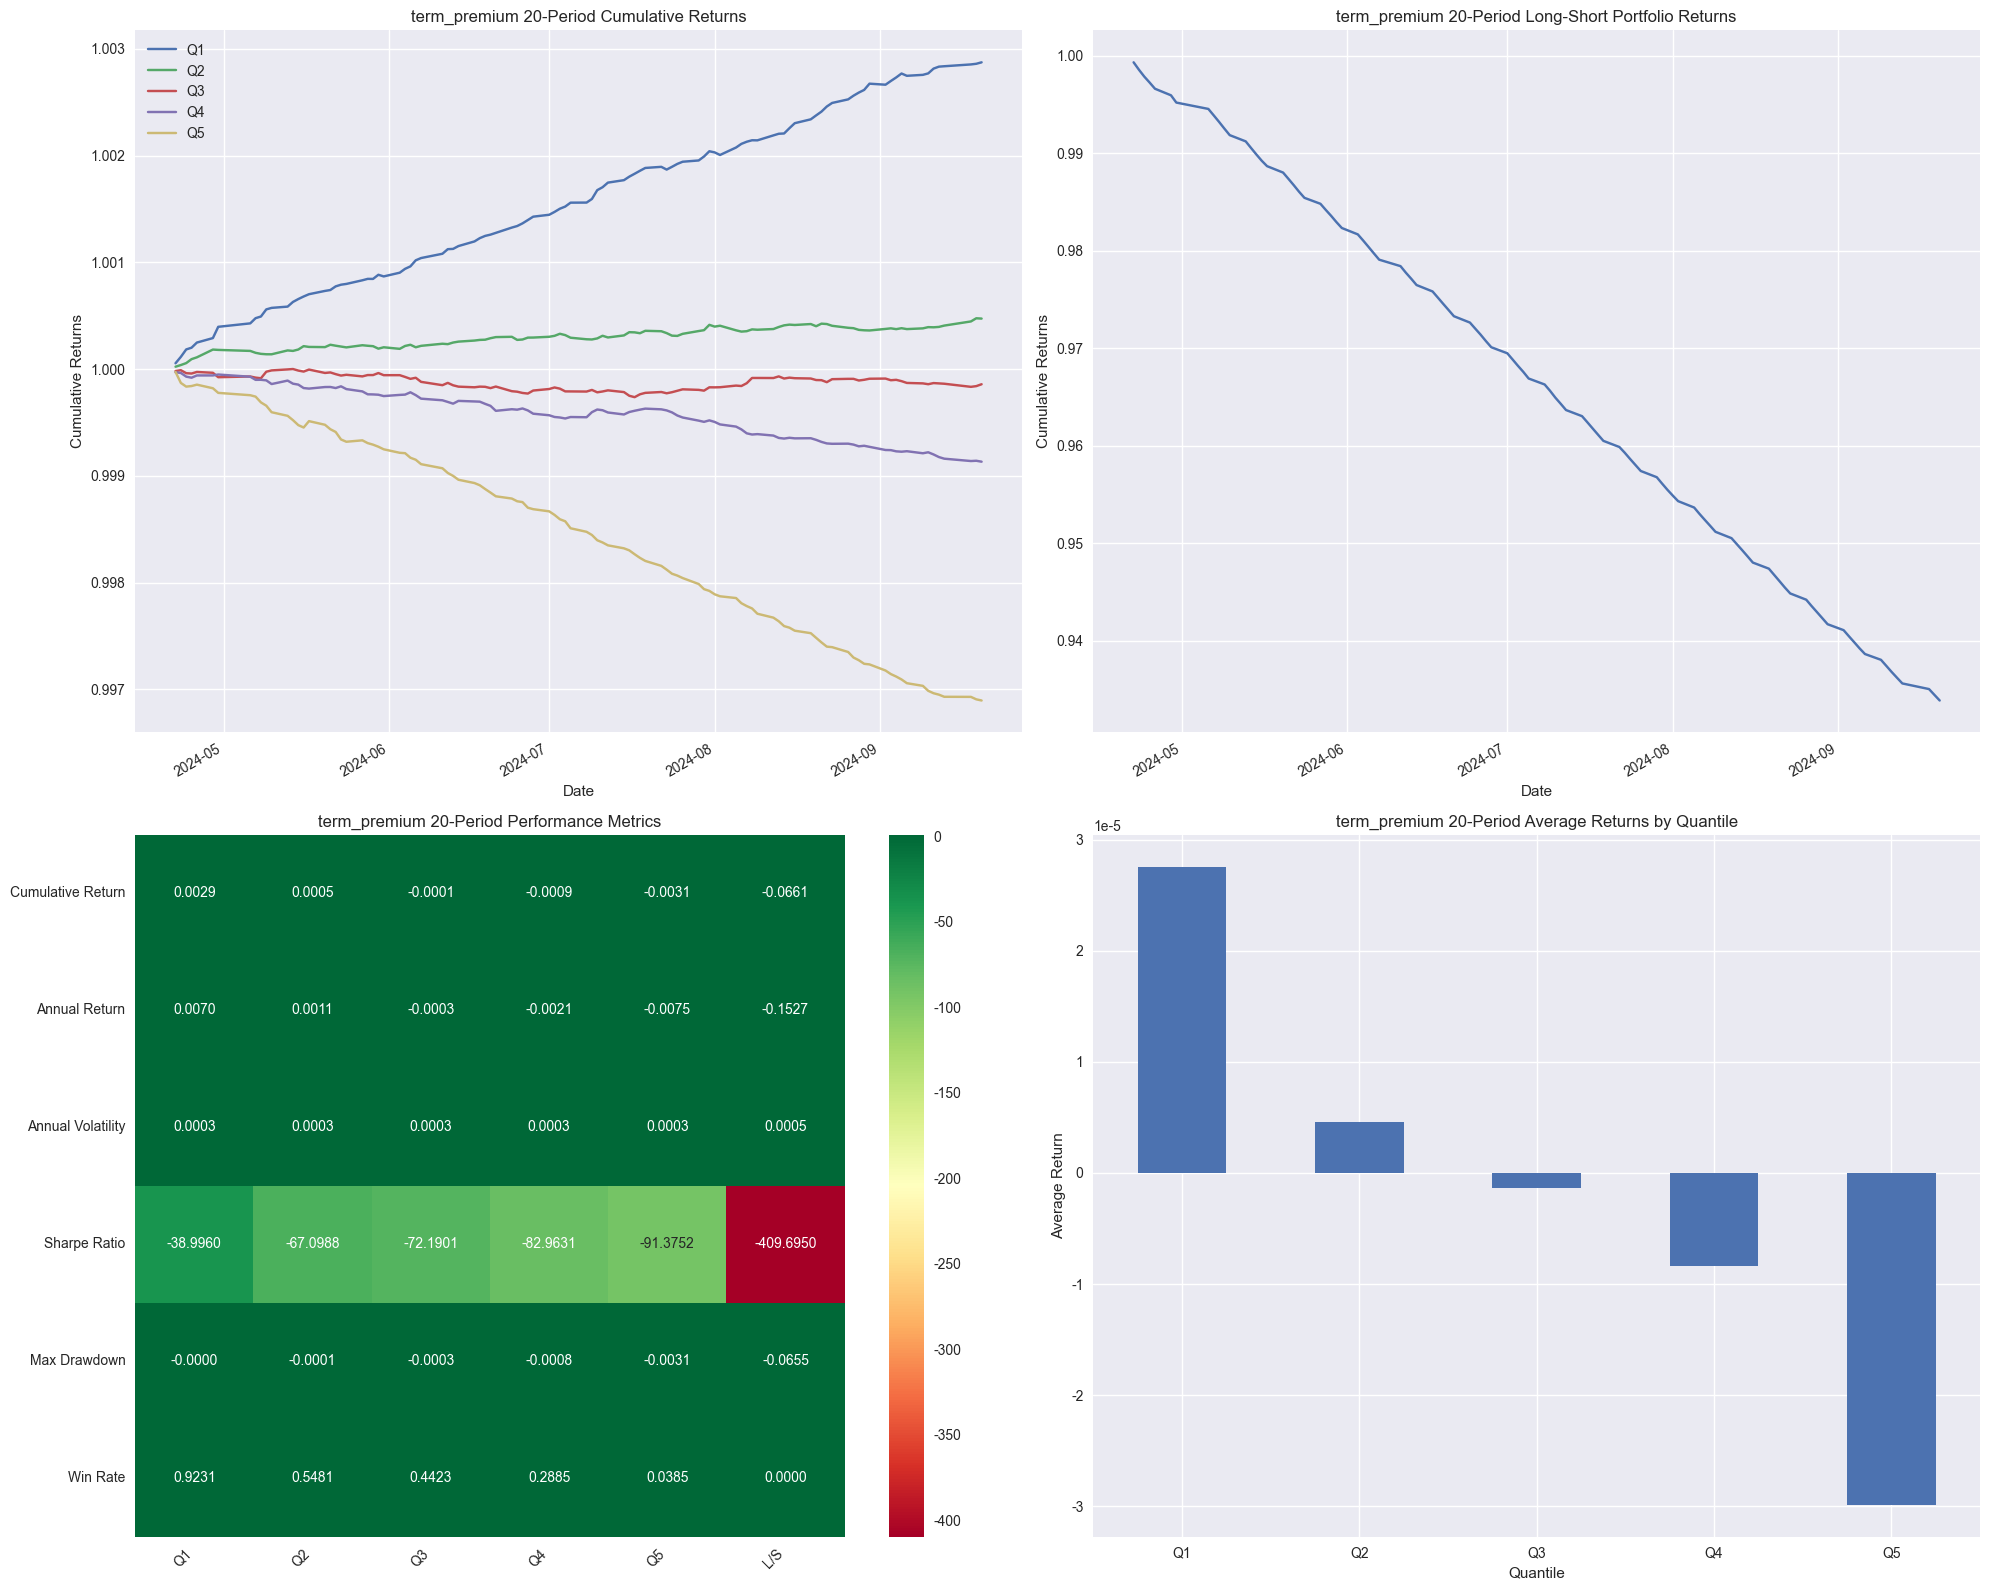


=== 测试复合类因子 ===

测试因子: volume_price_trend

计算收益率周期: [1, 5, 10, 20]

原始数据形状: (1899132, 70)

开始计算因子: volume_price_trend
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_date', 'd

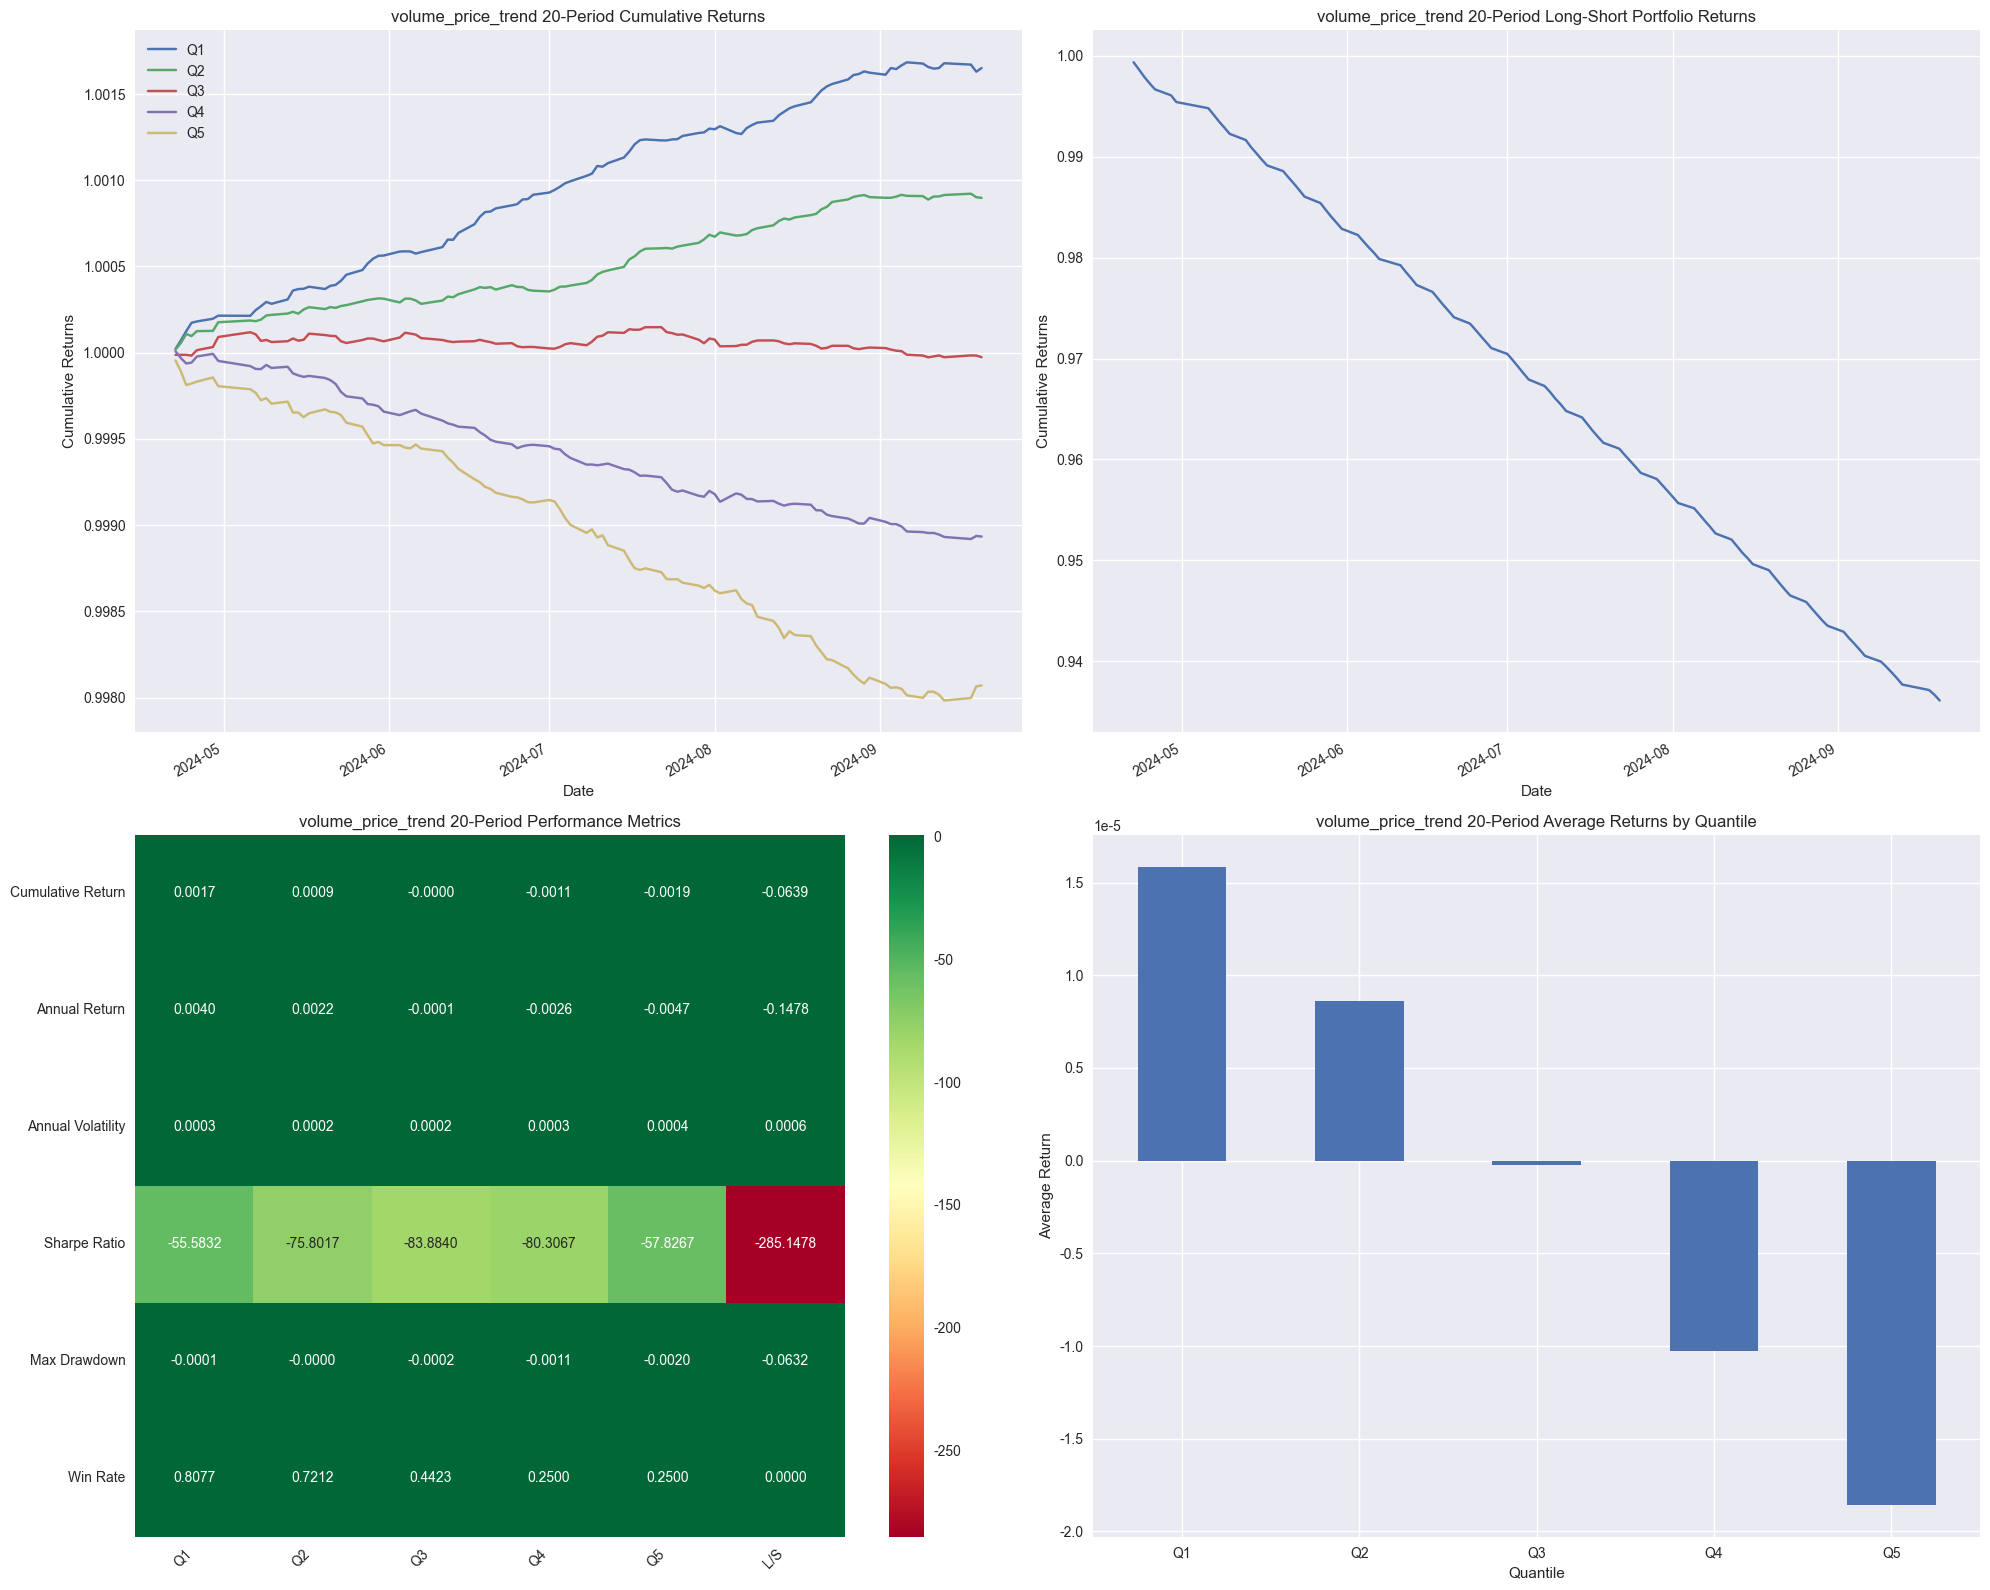


测试因子: liquidity_adjusted_momentum

计算收益率周期: [1, 5, 10, 20]

原始数据形状: (1899132, 70)

开始计算因子: liquidity_adjusted_momentum
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_date', '

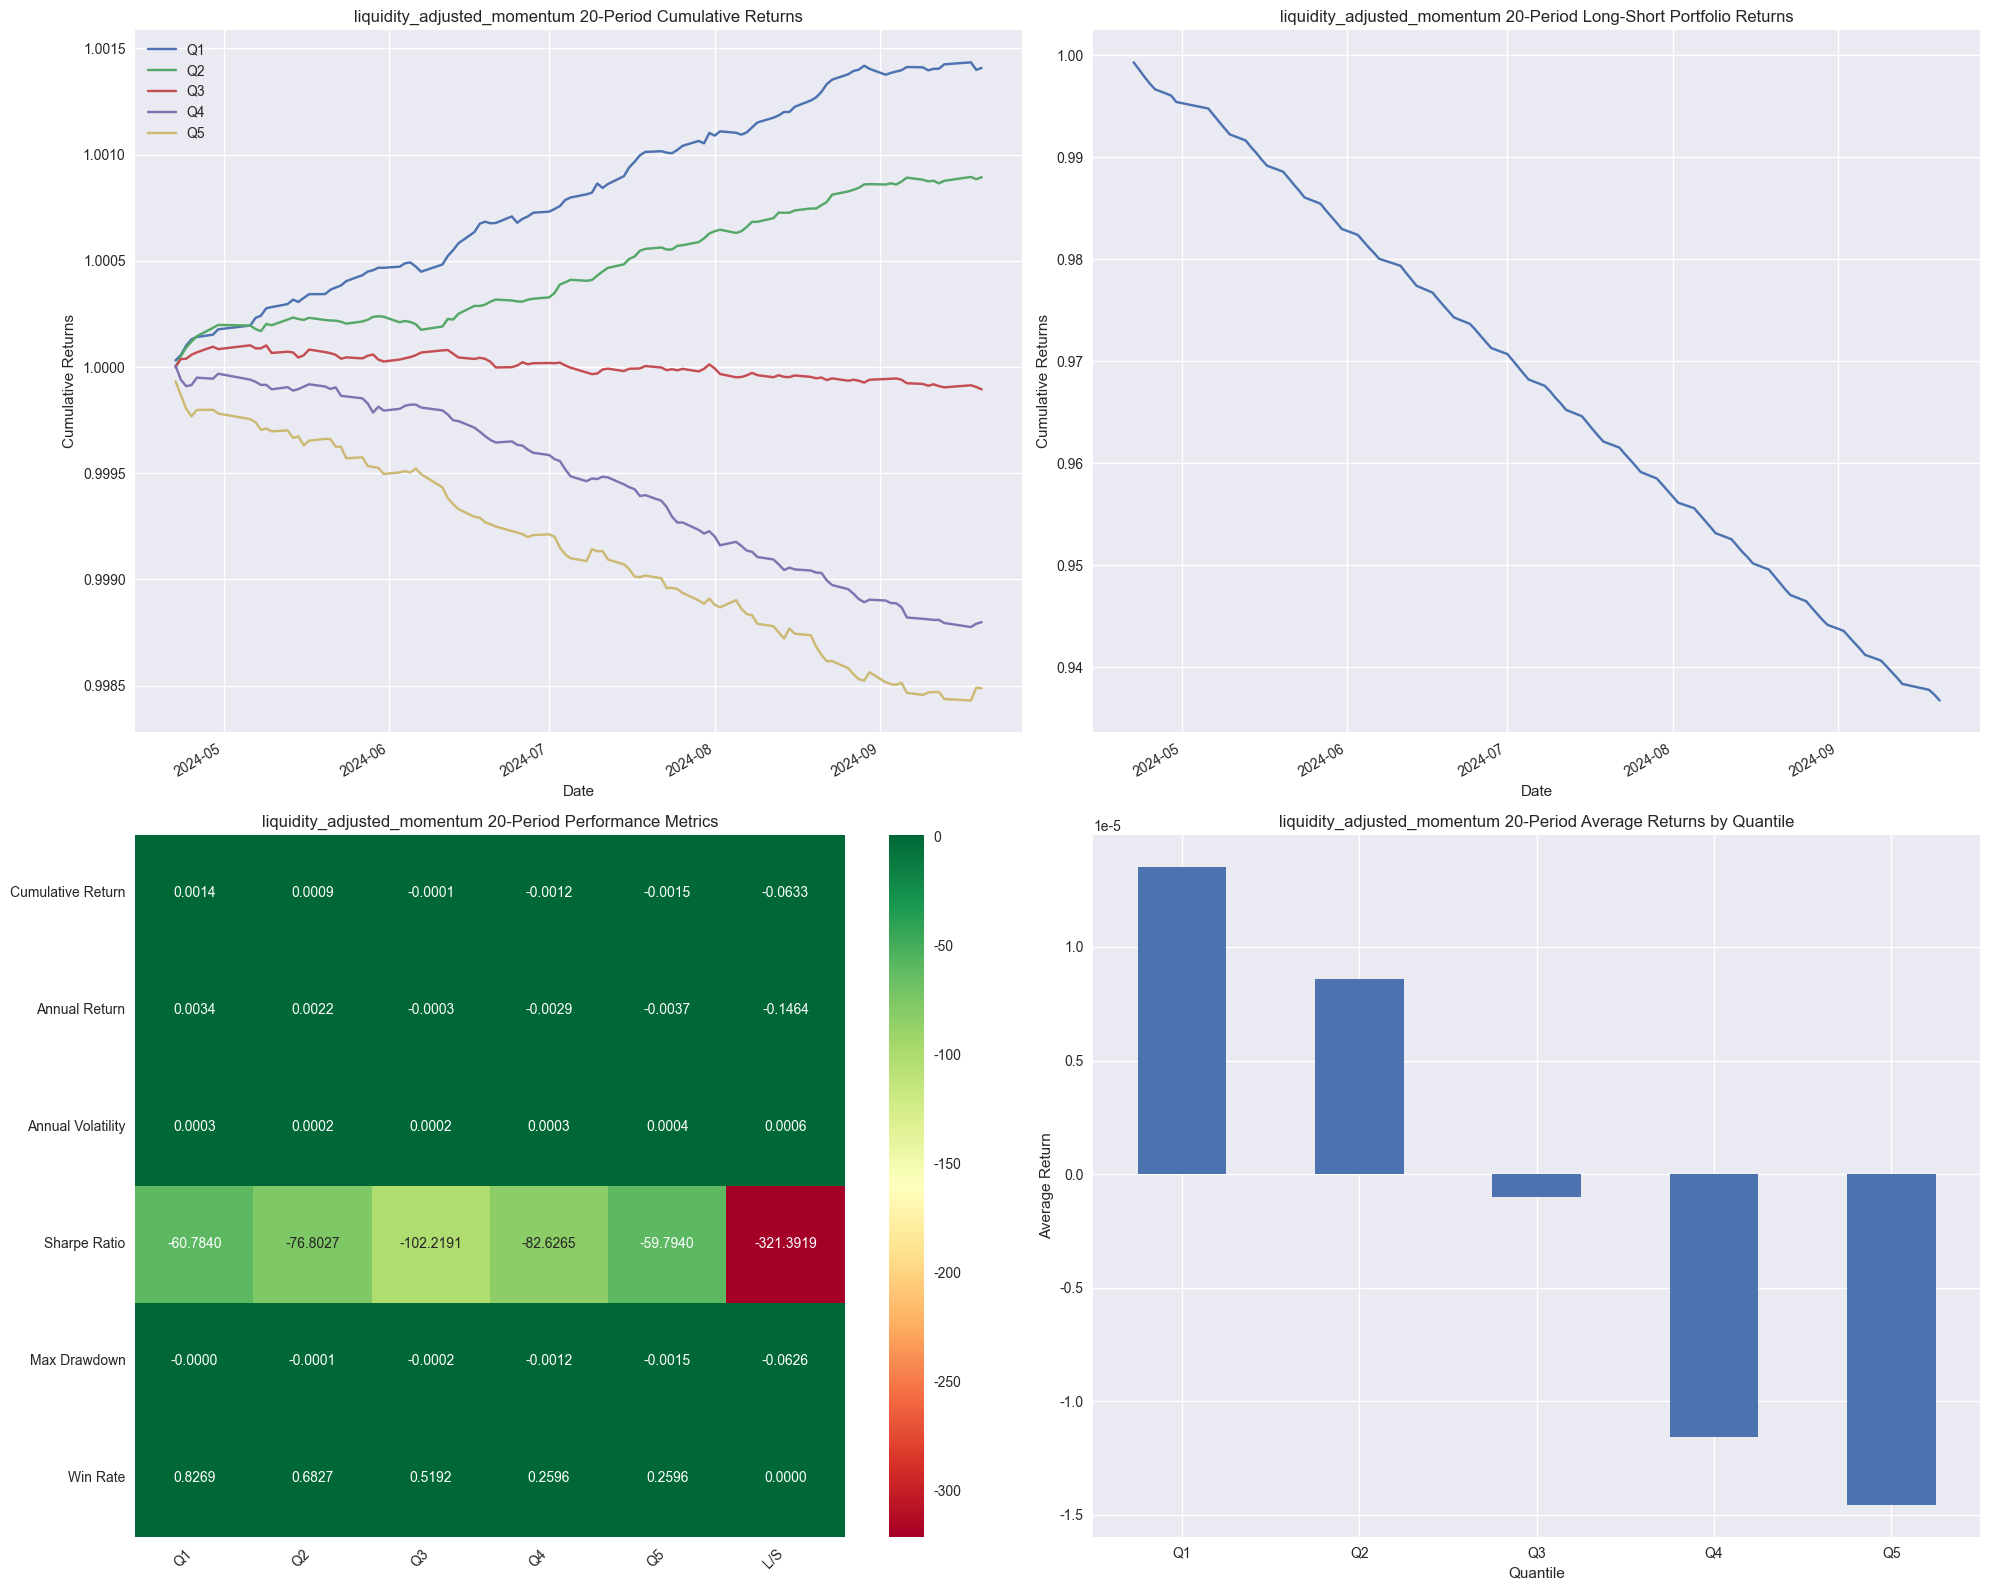


=== 批量计算所有新因子 ===

开始计算 4 个因子...

开始计算因子: intraday_seasonality
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_date', 'days_to_expiry', 'returns', 'vol', 'turnover', 'vwap', '

/Users/okko_dyd/Desktop/富国实习/factor_register.py:404: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  result['minute'] = pd.to_datetime(result['UpdateTime']).dt.minute



因子计算完成!
因子 intraday_seasonality 计算完成

开始计算因子: term_premium
数据列名: ['TradDay', 'UpdateTime', 'InstruID', 'LastPrice', 'HighPrice', 'LowPrice', 'OpenPrice', 'Volume', 'LastVolume', 'Turnover', 'OpenInt', 'PreOpenInt', 'OpenIntChg', 'ClosePrice', 'SetPrice', 'PreSetPrice', 'PreCloPrice', 'BuyVolume', 'SellVolume', 'AvgBuyPrice', 'AvgSellPrice', 'BidPrice1', 'BidPrice2', 'BidPrice3', 'BidPrice4', 'BidPrice5', 'AskPrice1', 'AskPrice2', 'AskPrice3', 'AskPrice4', 'AskPrice5', 'BidVolume1', 'BidVolume2', 'BidVolume3', 'BidVolume4', 'BidVolume5', 'AskVolume1', 'AskVolume2', 'AskVolume3', 'AskVolume4', 'AskVolume5', 'DerBidVolume1', 'DerBidVolume2', 'DerBidVolume3', 'DerBidVolume4', 'DerBidVolume5', 'DerAskVolume1', 'DerAskVolume2', 'DerAskVolume3', 'DerAskVolume4', 'DerAskVolume5', 'ULimitPrice', 'LLimitPrice', 'InstruCode', 'DateTime', 'hour', 'minute', 'second', 'day_of_week', 'session', 'is_holiday', 'is_overnight', 'expiry_date', 'days_to_expiry', 'returns', 'vol', 'turnover', 'vwap', 'spre

In [1]:
import pandas as pd
from factor_compute import run_factor_compute, compute_multiple_factors
from factors_test import FactorTestConfig

df = pd.read_feather("data.feather")

time_factors = ["intraday_seasonality"]
print("\n=== 测试时间特征类因子 ===")
for factor in time_factors:
    print(f"\n测试因子: {factor}")
    results = run_factor_compute(
        df, 
        factor_name=factor,
        return_periods=[1, 5, 10, 20],  
        config=FactorTestConfig(
            ic_method='spearman',
            n_quantiles=5,
            min_sample_size=30
        )
    )

term_factors = ["term_premium"]
print("\n=== 测试期限结构类因子 ===")
for factor in term_factors:
    print(f"\n测试因子: {factor}")
    results = run_factor_compute(
        df, 
        factor_name=factor,
        return_periods=[5, 10, 20],  
        config=FactorTestConfig(
            ic_method='spearman',
            n_quantiles=5,
            min_sample_size=50  
        )
    )

composite_factors = [
    "volume_price_trend",
    "liquidity_adjusted_momentum",
]
print("\n=== 测试复合类因子 ===")
for factor in composite_factors:
    print(f"\n测试因子: {factor}")
    results = run_factor_compute(
        df, 
        factor_name=factor,
        return_periods=[1, 5, 10, 20],
        config=FactorTestConfig(
            ic_method='spearman',
            n_quantiles=5,
            min_sample_size=30,
            ic_threshold=0.02,  
            ir_threshold=0.5   
        )
    )

all_new_factors = time_factors + term_factors + composite_factors
print("\n=== 批量计算所有新因子 ===")
df_with_factors = compute_multiple_factors(df, all_new_factors)

